## Jupyter Extensions - convenience as an extension
For Jupyter to bring more added value I recommend you to install extensions
pip Commands:

pip install jupyter_nbextensions_configurator jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextensions_configurator enable --user

My Favorites are:
* Collapsible headings
* Code folding
* Notify
* Hinterland (can be nice, but I think I didn't come to use it correctly)
              
Thanks to https://becominghuman.ai/enhance-your-jupyter-experience-with-these-notebook-widgets-a2717921f678

In [1]:
# stretch the code to 90% of the browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Downloading data from Yahoo
Enter symbol, from , to, path

In [2]:
r'''
import yahoofinance as yf
symbol ='O.DE'
from = '2014-10-31'
to = '2020-11-11'
path = r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\TecDAX/'
hist = yf.HistoricalPrices(symbol,  from, to, frequency='1d')
hist.to_csv(path + symbol + '.csv')
'''

## Imports

In [3]:
import datetime
import glob
import webbrowser
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
import sys
from scipy.stats import linregress
import quantstats as qs
import seaborn as sns
import optunity.metrics

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imports for walkforward analysis
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np
import backtrader as bt
import backtrader.indicators as btind
import datetime as dt
import pandas as pd
import pandas_datareader as web
from pandas import Series, DataFrame
import random
from copy import deepcopy
import optunity.metrics
import backtrader.analyzers as btanal

c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Fill in gaps of survivorship bias free data

In [4]:
r'''
import pandas as pd
import glob, os, datetime
pathh = r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\data/'
idx = pd.date_range('2013-02-28', '2018-02-28')
for fname in glob.glob(os.path.join(pathh, '*')):
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    df1 = df.reindex(idx,fill_value=0)
    df1.to_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\data2/' + os.path.basename(fname).replace(".csv", "") + '_1.csv')
    #print(df1)
    #break
'''   

'\nimport pandas as pd\nimport glob, os, datetime\npathh = r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\data/\'\nidx = pd.date_range(\'2013-02-28\', \'2018-02-28\')\nfor fname in glob.glob(os.path.join(pathh, \'*\')):\n    df = pd.read_csv(fname, index_col=0, parse_dates=True)\n    df1 = df.reindex(idx,fill_value=0)\n    df1.to_csv(r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\data2/\' + os.path.basename(fname).replace(".csv", "") + \'_1.csv\')\n    #print(df1)\n    #break\n'

## Parameters

In [5]:
globalparams = dict(path=r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\Momentum Stocks', # location of your csv files downloaded from Yahoo
                    fromdate=datetime.datetime(2014, 11, 3),
                    todate=datetime.datetime(2020, 6, 18),
                    cash=100000,            
                    commission=0.005,
                    reserve=0.05,
                    selcperc=0.06,  # percentage of stocks to select from the universe
                    strategy="St", #HSt = Buy and Hold, St = Standard Strategy for non-survivorship free bias momentum
                    heatmap=True,  #Does not work with Hold and Buy
                    optunity=False,
                    printlog=True,
                    walk=True,     #switch on Walk-forward-analysis
                    )

## Function section
Momentum (with and without volatility correction) [thanks to Teddy Koker https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/] and heatmap for analysis of variable combinations

In [6]:
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

def momentum_func1(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized

class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    func = momentum_func1

# Great Heatmap to analyse Output of opstrategy
def my_heatmap(data):
    data = np.array(data)
    xs = np.unique(data[:, 0].astype(int))
    ys = np.unique(data[:, 1].astype(int))
    vals = data[:, 3].reshape(len(ys), len(xs))
    min_val_ndx = np.unravel_index(np.argmin(vals, axis=None), vals.shape)
    max_val_ndx = np.unravel_index(np.argmax(vals, axis=None), vals.shape)

    cmap = LinearSegmentedColormap.from_list('', ['red', 'orange', 'yellow', 'chartreuse', 'limegreen'])
    ax = sns.heatmap(vals, xticklabels=xs, yticklabels=ys, cmap='viridis', annot=True, fmt='.2f')

    ax.add_patch(Rectangle(min_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    ax.add_patch(Rectangle(max_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    plt.tight_layout()
    plt.show()
    
def my_scatter_plot(data):
    # create data
    x = []
    y = []
    z = []
    for i in range(0, len(data)):
        x.append(data[i][1])
        y.append(data[i][0])
        z.append(round(data[i][3],0))
    '''
    # Change color with c and alpha. I map the color to the X axis value.
    sc = plt.scatter(x, y, s=z, c=z, cmap="viridis", alpha=0.4)
    plt.legend(*sc.legend_elements("sizes", num=6), loc=4)
    # Add titles (main and on axis)
    plt.xlabel("the X axis")
    plt.ylabel("the Y axis")
    plt.title("A colored bubble plot")
    '''
    df = pd.DataFrame(dict(x=x, y=y, z=z))
    sns.set_context("talk")
    #plt.figure(figsize=(10,6))
    pp=sns.scatterplot(x=x, 
                    y=y,
                    size=z,
                    sizes=(20,500),
                    alpha=0.5,
                    data=df)
    
    for line in range(0,df.shape[0]):
        pp.text(df.x[line]+0.2, df.y[line], df.z[line], horizontalalignment='left', size='medium', color='black')
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
                      
    plt.show()

## Simple Buy and Hold Strategy
Thanks to https://github.com/samuel281/qu-ant/blob/master/lib/strategies/hold_all_strategy.py

In [7]:
class HSt(bt.Strategy):
    params = dict(
        buy_date=datetime.datetime.today().isoformat(),
    )
    
    def __init__(self):
        self.stocks = self.datas[2:] #must filter out bond and spy 
                  
    def next(self):
        for d in self.stocks:
            if self.getposition(data=d).size:
                return
        
        if self.data.datetime.date(0).isoformat() < self.params.buy_date.isoformat(): #buydate must be determined by the first strategy, since it is the date of the first trade?
            return

        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.stocks)            
        for d in self.stocks:
            self.order_target_percent(data=d, target=target_ratio_per_sec)            
    
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))            
            
    def on_order_executed(self, order):
        pass
    
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():

                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash(), self.broker.getvalue()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size, self.broker.getvalue()))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
       

## Survivor bias free momentum strategy
Thanks to 

In [8]:
class Sur(bt.Strategy):
    params = dict(
            selcperc=0.10,  # percentage of stocks to select from the universe
            rperiod=1,  # period for the returns calculation, default 1 period
            vperiod=55,  # lookback period for volatility - default 36 periods
            mperiod=155,  # lookback period for momentum - default 90 periods
            momentum=Momentum, # parametrize the momentum and its period
            reserve=globalparams["reserve"],  # 5% reserve capital
            monthdays=[1],
            monthcarry=True,
            when=bt.timer.SESSION_START,
            benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
            SMAperiod=200,
            benchmark_bond=True, # Sell all Stocks and buy Bonds
            jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                                # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
            jump_one=0.6,
            printlog=True,
        )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        self.stocks_len = []
        
        jump = True

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma


    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''       
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
              format(timer.p.tid, when, int(self._getminperstatus())))
        print("timer")
        if self._getminperstatus() < 0:
            self.rebalance()
    
    def nextstart(self):
        self.ranks_filter = self.ranks
        print("nextstart")
        self.next()
        
    def prenext(self):
        self.stocks_len = [d for d in self.stocks if len(d)]
        self.ranks_filter = dict(zip(self.stocks_len, [self.ranks[k] for k in self.stocks_len]))        
        self.next()
        
    def next(self):
        print("next")
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        print("rebalance")
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks_filter.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return
        
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                    return #Code stops here and skips rebalancing und buying

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
        
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        print('Final PnL: {}'.format(
            pnl))

## Momentum Strategy
Originally it is a combination of the momentum strategy example given on the official website:
https://www.backtrader.com/blog/2019-05-20-momentum-strategy/momentum-strategy/
and  https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
Changes have been made:
* Triple momentum, i.e. if benmarkstop is True, benchmark index is below SMAperiod no stocks will be bought anymore. 
If benchmark_bond is True all stocks will be sold and bond of choice will be bought
* Sizer has been adapted to equal distribution of free cash and not equal share among all stocks
* 

In [9]:
class St(bt.Strategy):
    params = dict(
        selcperc=globalparams["selcperc"],  # percentage of stocks to select from the universe
        rperiod=1,  # period for the returns calculation, default 1 period
        vperiod=45,  # lookback period for volatility - default 36 periods
        mperiod=190,  # lookback period for momentum - default 90 periods
        momentum=Momentum, # parametrize the momentum and its period
        reserve=globalparams["reserve"],  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        weekdays=[5],
        weekcarry=True,
        weeks_between=1,
        when=bt.timer.SESSION_START,
        benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
        SMAperiod=100,
        benchmark_bond=True, # Sell all Stocks and buy Bonds
        jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                            # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
        jump_one=0.6,
        printlog=globalparams["printlog"],
        WFA=False,          #Switch for the last "putting the fragments together run" of the Walk Forward Analysis
        start_dates=None,  # Starting days for trading periods (a list)
        end_dates=None, 
    )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        self.timer_i = 0
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            #weekdays=self.p.weekdays,
            #weekcarry=self.p.weekcarry
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        jump = True

        # preparation for Walk Forward Analysis
        if self.p.WFA == True:
            self.mperiod = dict()
            self.vperiod = dict()
            self.ms = dict()

            self.date_combos = [c for c in zip(self.p.start_dates, self.p.end_dates)]

            # Additional indexing, allowing for differing start/end dates
            for sd, ed, f, s in zip(self.p.start_dates, self.p.end_dates, self.p.mperiod, self.p.vperiod):

                # returns, volatilities and momentums
                #self.ms[(sd, ed)] = [bt.ind.ROC(d, period=f) for d in self.stocks] # alternative momentum indicator
                self.ms[(sd, ed)] = [self.p.momentum(d, period=f) for d in self.stocks]

                #self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)

                #self.bench_filter = self.bench < self.bench_sma
        
        #Non walk forward analysis
        else:
            # returns, volatilities and momentums
            rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
            vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
            #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas] # alternative momentum indicator
            ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]

            self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)

            # simple rank formula: (momentum * net payout) / volatility
            # the highest ranked: low vol, large momentum, large payout
            self.ranks = {d: m for d, v, m in zip(self.stocks, vs, ms)}

            self.bench_filter = self.bench < self.bench_sma
                
    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                self.log('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                self.log('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                self.log('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                self.log('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
           
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        #print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
        #      format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            self.timer_i += 1
            if self.timer_i == self.p.weeks_between:
                self.timer_i = 0
                self.rebalance()
  
    def next(self):
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        
        # Walkforward Analysis Section (no triple momentum possible)
        if self.p.WFA == True:
            # Determine which set of moving averages to use
            curdate = self.datetime.date(0)
            dtidx = None  # Will be index
            # Determine which period (if any) we are in
            for sd, ed in self.date_combos:
                if sd <= curdate and curdate <= ed:
                    dtidx = (sd, ed)
                    self.ranks = {d: m for d, m in zip(self.stocks, self.ms[dtidx])}
                            # sort data and current rank
                    ranks = sorted(
                        self.ranks.items(),  # get the (d, rank), pair
                        key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
                        reverse=True,  # highest ranked 1st ... please
                    )

                    # put top ranked in dict with data as key to test for presence
                    rtop = dict(ranks[:self.selnum])

                    # For logging purposes of stocks leaving the portfolio
                    rbot = dict(ranks[self.selnum:])

                    # prepare quick lookup list of stocks currently holding a position
                    posdata = [d for d, pos in self.getpositions().items() if pos]
                    
            if dtidx is None:  # Not in any window
                pass # Don't engage in trades
            else:
                self.momentum_core(posdata, rtop, rbot)
                
                #test whether momentums differ over time
                #print(self.ms[dtidx][0][0], dtidx, " vs ", self.ms[datetime.date(2019, 8, 30), datetime.date(2020, 11, 10)][0][0])
        
        # Non walk forward section
        else:
            # sort data and current rank
            ranks = sorted(
                self.ranks.items(),  # get the (d, rank), pair
                key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
                reverse=True,  # highest ranked 1st ... please
            )

            # put top ranked in dict with data as key to test for presence
            rtop = dict(ranks[:self.selnum])

            # For logging purposes of stocks leaving the portfolio
            rbot = dict(ranks[self.selnum:])

            # prepare quick lookup list of stocks currently holding a position
            posdata = [d for d, pos in self.getpositions().items() if pos]
            #if jump == True:
            # Enter Jump Code here    


            if self.p.benchmarkstop:
                for d in (d for d in posdata):
                    if "Bond" == d._name and self.bench_filter:
                        return
                    else:
                        if "Bond" == d._name and not self.bench_filter:
                            self.order_target_percent("Bond", target=0.0)
                            self.log('Leave {} due to end of down period'.format(d._name))
                            return

            # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
            if self.p.benchmarkstop:
                if self.bench_filter:
                    #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                    if self.p.benchmark_bond:
                        for d in posdata:
                            self.log('Leave {} due to switch to Bonds'.format(d._name))
                            self.order_target_percent(d, target=0.0)
                        self.order_target_percent("Bond", target=0.95)
                        self.log('Buy Bond')
                        bond_flag = True
                    return #Code stops here and skips rebalancing und buying
                
            self.momentum_core(posdata, rtop, rbot)
            
    def momentum_core(self, posdata, rtop, rbot):
        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)

        sum_stocks = 0
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            #self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            #self.order_target_percent(d, target=self.perctarget)
            #Rebalances are just pricy operations which are needed for the buying part ... since it was based on equal weights...
            del rtop[d]  # remove it, to simplify next iteration
            sum_stocks += self.broker.getposition(d).size * self.broker.getposition(d).adjbase # Calulate the value of the stocks owned


        if len(rtop):
            sizer_perc = (0.95 - sum_stocks / self.broker.get_value()) / len(rtop) # Have a equal sizer for the cash (you want to invest in)
            sum_stocks = 0

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=sizer_perc)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        self.log('Final PnL: {}'.format(
            pnl))

## Walk forward analysis
Thanks to https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/

In [10]:
def walk_forward_analysis(datafeeds):

    # display dataframes more orderly
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.width', 1000)

    globalparameters = dict(strategy=globalparams['strategy'],            # if a different strategy is used
                        n_splits=6,                # how many chunks the data should have
                        fixed_length=False,         # by setting it False the training data will will grow over time, otherwise it will keep the size given under train_splits
                        train_splits=1,             # how many splits should be used to train the model (be aware of these two variables may not work with your strategy, i.e. SMA100 but two training splits are just 110 days or less than 100 days)
                        test_splits=1,              # how many splits should the data be tested on?
                        cash=globalparams["cash"],
                        commission=0.02,
                        coc=True,
                        num_evals=2,               # how often should the optimizer try to optimize
                        var1range=[2, 200],        # reasonable range within the optimization should happen (variable 1)
                        var2range=[2, 3],        # reasonable range within the optimization should happen (variable 2)
                        )


    class TimeSeriesSplitImproved(TimeSeriesSplit):
        """Time Series cross-validator
        Provides train/test indices to split time series data samples
        that are observed at fixed time intervals, in train/test sets.
        In each split, test indices must be higher than before, and thus shuffling
        in cross validator is inappropriate.
        This cross-validation object is a variation of :class:`KFold`.
        In the kth split, it returns first k folds as train set and the
        (k+1)th fold as test set.
        Note that unlike standard cross-validation methods, successive
        training sets are supersets of those that come before them.
        Read more in the :ref:`User Guide `.
        Parameters
        ----------
        n_splits : int, default=3
            Number of splits. Must be at least 1.
        Examples
        --------
        >>> from sklearn.model_selection import TimeSeriesSplit
        >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
        >>> y = np.array([1, 2, 3, 4])
        >>> tscv = TimeSeriesSplit(n_splits=3)
        >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
        TimeSeriesSplit(n_splits=3)
        >>> for train_index, test_index in tscv.split(X):
        ...    print("TRAIN:", train_index, "TEST:", test_index)
        ...    X_train, X_test = X[train_index], X[test_index]
        ...    y_train, y_test = y[train_index], y[test_index]
        TRAIN: [0] TEST: [1]
        TRAIN: [0 1] TEST: [2]
        TRAIN: [0 1 2] TEST: [3]
        >>> for train_index, test_index in tscv.split(X, fixed_length=True):
        ...     print("TRAIN:", train_index, "TEST:", test_index)
        ...     X_train, X_test = X[train_index], X[test_index]
        ...     y_train, y_test = y[train_index], y[test_index]
        TRAIN: [0] TEST: [1]
        TRAIN: [1] TEST: [2]
        TRAIN: [2] TEST: [3]
        >>> for train_index, test_index in tscv.split(X, fixed_length=True,
        ...     train_splits=2):
        ...     print("TRAIN:", train_index, "TEST:", test_index)
        ...     X_train, X_test = X[train_index], X[test_index]
        ...     y_train, y_test = y[train_index], y[test_index]
        TRAIN: [0 1] TEST: [2]
        TRAIN: [1 2] TEST: [3]
        Notes
        -----
        When ``fixed_length`` is ``False``, the training set has size
        ``i * train_splits * n_samples // (n_splits + 1) + n_samples %
        (n_splits + 1)`` in the ``i``th split, with a test set of size
        ``n_samples//(n_splits + 1) * test_splits``, where ``n_samples``
        is the number of samples. If fixed_length is True, replace ``i``
        in the above formulation with 1, and ignore ``n_samples %
        (n_splits + 1)`` except for the first training set. The number
        of test sets is ``n_splits + 2 - train_splits - test_splits``.
        """

        def split(self, X, y=None, groups=None, fixed_length=False,
                  train_splits=1, test_splits=1):
            """Generate indices to split data into training and test set.
            Parameters
            ----------
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples
                and n_features is the number of features.
            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.
            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.
            fixed_length : bool, hether training sets should always have
                common length
            train_splits : positive int, for the minimum number of
                splits to include in training sets
            test_splits : positive int, for the number of splits to
                include in the test set
            Returns
            -------
            train : ndarray
                The training set indices for that split.
            test : ndarray
                The testing set indices for that split.
            """
            X, y, groups = indexable(X, y, groups)
            n_samples = _num_samples(X)
            n_splits = self.n_splits
            n_folds = n_splits + 1
            train_splits, test_splits = int(train_splits), int(test_splits)
            if n_folds > n_samples:
                raise ValueError(
                    ("Cannot have number of folds ={0} greater"
                     " than the number of samples: {1}.").format(n_folds,
                                                                 n_samples))
            if ((n_folds - train_splits - test_splits) == 0 and test_splits > 0):
                raise ValueError(
                    ("Both train_splits and test_splits must be positive"
                     " integers."))
            indices = np.arange(n_samples)
            split_size = (n_samples // n_folds)
            test_size = split_size * test_splits
            train_size = split_size * train_splits
            test_starts = range(train_size + n_samples % n_folds,
                                n_samples - (test_size - split_size),
                                split_size)

            if fixed_length:
                for i, test_start in zip(range(len(test_starts)),
                                         test_starts):
                    rem = 0
                    if i == 0:
                        rem = n_samples % n_folds
                    yield (indices[(test_start - train_size - rem):test_start],
                           indices[test_start:test_start + test_size])
            else:
                for test_start in test_starts:
                    yield (indices[:test_start],
                           indices[test_start:test_start + test_size])

    class AcctStats(bt.Analyzer):
        """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""

        def __init__(self):
            self.start_val = self.strategy.broker.get_value()
            self.end_val = None

        def stop(self):
            self.end_val = self.strategy.broker.get_value()

        def get_analysis(self):
            return {"start": self.start_val, "end": self.end_val,
                    "growth": self.end_val - self.start_val, "return": self.end_val / self.start_val}

    for df in datafeeds.values():
        df["OpenInterest"] = 0  # PandasData reader expects an OpenInterest column;

    tscv = TimeSeriesSplitImproved(globalparameters['n_splits'])
    split = tscv.split(datafeeds[list(datafeeds.keys())[2]], fixed_length=globalparameters['fixed_length'], train_splits=globalparameters['train_splits'], test_splits=globalparameters['test_splits'])
    walk_forward_results = list()
    
    heatmap_data = []
    # Be prepared: this will take a while
    i = 0
    for train, test in split:
        i += 1
        # TRAINING
        # Optimize with optunity
        def runstrat(var1, var2):
            cerebro = bt.Cerebro(stdstats=False, maxcpus=None)
            cerebro.addstrategy(eval(globalparameters['strategy']), mperiod=int(var1), vperiod=int(var2), printlog=False, WFA=False)  # toDO make the float int choice switchable
            cerebro.broker.setcash(globalparameters['cash'])
            cerebro.broker.setcommission(globalparameters['commission'])
            for s, df in datafeeds.items():
                data = bt.feeds.PandasData(dataname=df.iloc[train], name=s)  # Add a subset of data
                cerebro.adddata(data)
            cerebro.broker.set_coc(globalparameters['coc'])
            cerebro.run()
            
            if globalparams["heatmap"]:
                heatmap_data.append([int(var1), i, 0,(cerebro.broker.getvalue()-globalparams["cash"])/globalparams["cash"]])
                
            return cerebro.broker.getvalue()  # ToDo make the variable that should be optimized flexible
        
        # Optunity if needed
        #opt = optunity.maximize(runstrat, num_evals=globalparameters['num_evals'], var1=globalparameters['var1range'], var2=globalparameters['var2range'])
        
        if globalparams["heatmap"]:
            results_list = []
            for j in np.arange(30, 210, 10):
                    runstrat(var1=j, var2=2)
        
        # Optunity results
        '''
        optimal_pars, details, _ = opt
        optimal_pars['var1'] = int(optimal_pars['var1'])
        optimal_pars['var2'] = int(optimal_pars['var2'])
        '''
        
        optimal_pars = {}
        #best return from the heatmap loop
        #print(max(heatmap_data, key=lambda x: x[3] if (x[1] == i) else 0), max(heatmap_data, key=lambda x: x[3] if (x[1] == i) else 0)[0], datafeeds[list(datafeeds.keys())[2]].iloc[test[0]].name)
        optimal_pars['var1'] = max(heatmap_data, key=lambda x: x[3] if (x[1] == i) else 0)[0]
        optimal_pars['var2'] = 2
        
        # TESTING
        tester = bt.Cerebro(stdstats=False, maxcpus=None)
        tester.broker.set_cash(globalparameters['cash'])
        tester.broker.set_coc(globalparameters['coc'])
        tester.broker.setcommission(globalparameters['commission'])
        tester.addanalyzer(AcctStats)
        tester.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)

        tester.addstrategy(eval(globalparameters['strategy']), mperiod=optimal_pars['var1'],
                           vperiod=optimal_pars['var2'], WFA=False, printlog=False)  # Test with optimal combination toDO like above int vs float
        for s, df in datafeeds.items():
            data = bt.feeds.PandasData(dataname=df.iloc[test], name=s)  # Add a subset of data
            tester.adddata(data)

        res = tester.run()
        res_dict = res[0].analyzers.acctstats.get_analysis()
        res_dict["var1"] = optimal_pars['var1']
        res_dict["var2"] = optimal_pars['var2']
        res_dict["sharpe"] = res[0].analyzers.sharperatio.get_analysis()['sharperatio']
        res_dict["start_date"] = datafeeds[list(datafeeds.keys())[2]].iloc[test[0]].name
        res_dict["end_date"] = datafeeds[list(datafeeds.keys())[2]].iloc[test[-1]].name
        walk_forward_results.append(res_dict)
    
    if globalparams["heatmap"]:
        my_heatmap(heatmap_data)
        #my_scatter_plot(heatmap_data)
    
    wfdf = DataFrame(walk_forward_results)
    print(wfdf.loc[:, wfdf.columns != 'start'])

    cerebro_wf = bt.Cerebro(stdstats=False, maxcpus=None)

    for s, df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df, name=s, fromdate=wfdf.iloc[0, wfdf.columns.get_loc('start_date')], todate=wfdf.iloc[-1, wfdf.columns.get_loc('end_date')])
        
        cerebro_wf.adddata(data)  # Give the data to cerebro

    cerebro_wf.broker.setcash(globalparameters['cash'])
    cerebro_wf.broker.setcommission(globalparameters['commission'])
    cerebro_wf.broker.set_coc(globalparameters['coc'])

    cerebro_wf.addstrategy(eval(globalparams['strategy']),
                           # Give the results of the above optimization to SMACWalkForward (NOT OPTIONAL)
                           mperiod=[f for f in wfdf.var1],
                           vperiod=[s for s in wfdf.var2],
                           start_dates=[sd.date() for sd in wfdf.start_date],
                           end_dates=[ed.date() for ed in wfdf.end_date],
                           WFA=True,
                           )

    cerebro_wf.addobservermulti(bt.observers.BuySell)  # Plots up/down arrows
    cerebro_wf.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro_wf.addanalyzer(btanal.PyFolio)

    results = cerebro_wf.run()
    print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
    
    # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Walkforward '+ globalparams["strategy"] + " " + str(int(globalparams["selcperc"] * 100)) + "% stocks picked")
    webbrowser.open('stats.html')
        
    #cerebro_wf.plot(iplot=True)

## Exection section

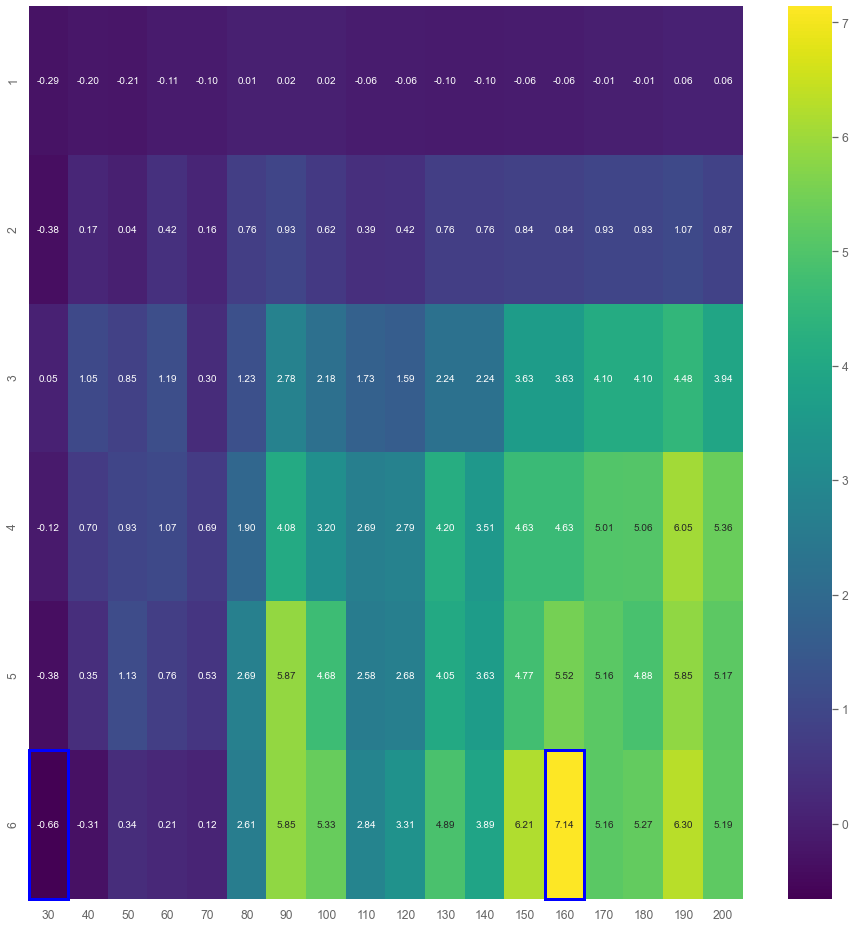

             end        growth    return  var1  var2    sharpe start_date   end_date
0  117482.724800  17482.724800  1.174827   190     2  0.447214 2015-09-21 2016-07-28
1  101232.298439   1232.298439  1.012323   190     2  0.500000 2016-07-29 2017-06-07
2  107203.611468   7203.611468  1.072036   190     2  0.447214 2017-06-08 2018-04-17
3  100101.046005    101.046005  1.001010   190     2  0.447214 2018-04-18 2019-02-26
4  127841.029501  27841.029501  1.278410    90     2  0.453535 2019-02-27 2020-01-03
5   90920.440439  -9079.559561  0.909204   160     2 -0.500000 2020-01-06 2020-11-10
2016-06-30 Enter NVDA - Rank 1.99
2016-07-05 Buy Submitted 2016-07-05 NVDA Price 46.66 Value 94999.76 Size 2036 Cash 3100.24
2016-07-05 Buy 2016-07-05 NVDA Price 46.66 Value 94999.76 Size 2036
2017-08-31 Leave NVDA - Rank 2.30
2017-08-31 Enter BABA - Rank 2.42
2017-09-05 Sell Submitted 2017-09-05 NVDA Price 170.46 Value -347056.57 Size -2036
2017-09-05 Buy Submitted 2017-09-05 BABA Price 171.04 Value 3

In [11]:
def run(args=None):
    #optreturn=False otherwise the heatmap doesn't work
    cerebro = bt.Cerebro(maxcpus=1,
                         preload=False,
		                 optdatas=False,
		                 optreturn=False,
		                 stdstats=True) 

    
# <<<Data loading section>>>
    
    # Parse from/to-date
    fromdate = globalparams["fromdate"]
    todate = globalparams["todate"]
    
    datafeeds = {}
    
    # Add SPY/QQQ as "Benchmark"
    df0 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\QQQ.csv', index_col=0, parse_dates=True)
    benchdata = bt.feeds.PandasData(dataname=df0,name="QQQ",fromdate=fromdate, todate=todate,  plot=False)
    cerebro.adddata(benchdata)
    datafeeds.update({"QQQ": df0})
    
    # Add TMF as "Bond"
    df1 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\TMF.csv', index_col=0, parse_dates=True)
    bonddata = bt.feeds.PandasData(dataname=df1,name="Bond",fromdate=fromdate, todate=todate, plot=False)
    cerebro.adddata(bonddata)
    datafeeds.update({"Bond": df1})
    
    
    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(globalparams["path"], '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)
        # Add dataframes to a dictionary for walkforward analysis
        datafeeds.update({os.path.basename(fname).replace(".csv", ""): df})
        if len(df)>200:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))
            #print(os.path.basename(fname).replace(".csv", "")) #prints the name of the added csv file
            
       
    # <<<Cerebro loading section>>>
    if globalparams["walk"]:
        walk_forward_analysis(datafeeds)
    else:
        # Optimization by Optunity (usually partical swarm if i remember correctly)
        def runstrat(p1, p2):
            cerebro = bt.Cerebro(maxcpus=0,stdstats=True)
            cerebro.addstrategy(St, selcperc=p1, mperiod=int(p2),printlog=False) #change the parameters that should be depicted in heatmap
            cerebro.broker.setcash(globalparams["cash"])
            cerebro.broker.setcommission(commission=globalparams["commission"])
            cerebro.adddata(benchdata)
            cerebro.adddata(bonddata)  
            for fname in glob.glob(os.path.join(globalparams["path"], '*')):
                df = pd.read_csv(fname, index_col=0, parse_dates=True)
                if len(df)>200:
                    cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))        

            cerebro.broker.set_coc(True)
            cerebro.run(maxcpus=0)
            return cerebro.broker.getvalue() #can be switched to whatever should be maximized/minimized

        #Either use Optunity for quick search of optimum
        if globalparams["optunity"]:
            opt = optunity.maximize(runstrat, num_evals=200, p1 = [1, 300], p2=[2, 100])

            optimal_pars, details, _ = opt
            print('Optimal Parameters:')
            print('maperiod1 = %.4f' % optimal_pars['p1'])
            print('maperiod2 = %.4f' % optimal_pars['p2'])


        # Heatmap showing how variables i = (y axis/ p1) and j = (x axis /p2) impact strategy outcome
        if globalparams["heatmap"]:
            results_list = []
            for i in np.arange(0.1, 0.51, 0.4):
                for j in np.arange(30, 200, 10):
                    PnL = runstrat(p1=i, p2=j)/globalparams["cash"]
                    results_list.append([i, j, i,PnL])
            my_heatmap(results_list)
            return


        # add strategy
        if globalparams["optunity"]:
            cerebro.addstrategy(eval(globalparams["strategy"]), mperiod=int(optimal_pars['p1']), vperiod=int(optimal_pars['p2']))
        elif globalparams["strategy"] == "HSt":
            cerebro.addstrategy(HSt, buy_date=datetime.date(2015, 8, 31))
        else:    
            cerebro.addstrategy(eval(globalparams["strategy"]))


        # set the cash, cheat on close and commission
        cerebro.broker.setcash(globalparams["cash"])
        cerebro.broker.set_coc(True)
        cerebro.broker.setcommission(commission=globalparams["commission"])

        # Adding Analysers
        #cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, _name='sharpe')
        cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
        cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio & Quanstat
        cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades

        # If you want to have all data written into a log file
        #cerebro.addwriter(bt.WriterFile, csv=True, out='log.csv')

        cerebro.addobserver(bt.observers.Benchmark,
                            data=benchdata,
                            timeframe=bt.TimeFrame.NoTimeFrame)

        results = cerebro.run(maxcpus=1)#maxcpu=1 otherwise pickling multiprocessing errors

        # <<<Performance analysing section section>>>

        cerebro.plot()

        # Basic performance evaluation ... final value ... minus starting cash
        pnl = cerebro.broker.get_value() - globalparams["cash"]
        print('Profit ... or Loss: {:.2f}'.format(pnl))

        # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
        # Does not work with optstrategy
        returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        qs.reports.html(returns, output='stats.html', title='Momentum '+ globalparams["strategy"] + " " + str(int(globalparams["selcperc"] * 100)) + "% stocks picked")
        webbrowser.open('stats.html')


        # Pyfolio if needed
        #returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
        #benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
        #pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    
# <<<Execute starting section>>>    
if __name__ == '__main__':
    run()

In [12]:
# how do the single stocks perform over the time frame
r'''
fdate = datetime.datetime(2015, 8, 31)
tdate = datetime.datetime(2020, 6, 18)
for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\DAX', '*')):
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    a = df.at[fdate,"Close"]
    b = df.at[tdate,"Close"]
    print(b/a-1)
'''

'\nfdate = datetime.datetime(2015, 8, 31)\ntdate = datetime.datetime(2020, 6, 18)\nfor fname in glob.glob(os.path.join(r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\DAX\', \'*\')):\n    df = pd.read_csv(fname, index_col=0, parse_dates=True)\n    a = df.at[fdate,"Close"]\n    b = df.at[tdate,"Close"]\n    print(b/a-1)\n'